<a href="https://colab.research.google.com/github/nuraishasb/supervisedML/blob/main/R_supervisedML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 | Introduction

In this report, we experiment the use of machine learning operators, mainly Supervised Learning, on 2 different data sets. We begin with the Classification analysis on the Breast Cancer data set, before moving on to the Regression analysis on the Boston data set.

# 2 | Classification Task

Classification is a type of supervised machine learning where algorithms learn from the data to predict an outcome or event in the future. In this part of the report, we will be using the Breast Cancer data set to predict the diagnosis of breast cancer.

### 2.1: EDA

We use exploratory data analysis (EDA) to investigate data sets and summarize their main characteristics, which can be done by employing data visualization methods.

The `str()` function provides information of the structure of the variables. It can be seen that the data set is mostly made up of numerical variables, with the the exception of variables `id`, `diagnosis` and `X`.

In [1]:
install.packages("googledrive")
library(googledrive)
drive_auth(use_oob = TRUE)

drive_download("breastcancer.csv", path = "breastcancer.csv")

data <- read.csv("breastcancer.csv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

The googledrive package is requesting access to your Google account.
Enter '1' to start a new auth process or select a pre-authorized account.
1: Send me to the browser for a new auth process.
2: nuraishasb@gmail.com


Selection: 2


In [2]:
#examining the structure of the data set
str(data)

'data.frame':	569 obs. of  33 variables:
 $ id                     : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : chr  "M" "M" "M" "M" ...
 $ radius_mean            : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave.points_mean    : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num  0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num  1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se             : num  0.905 0.734 0.787 1

Variable `X` is redundant as it does not contain any valuable information hence we remove it. The `is.na()` function checks the NA field in a data frame. We take the sum of the function to find the total number of NA values in our data set, which is 0.

In [3]:
#removing columns
BC <- data[-c(1,33)]
#finding if there are NA values
sum(is.na(BC))

[1] 0

As mentioned above, our aim in this section of the report is to predict the diagnosis of breast cancer, given the measurements of the tumor and breast mass. Thus, our dependent variable is the `diagnosis` variable. We start off by converting the variable into binary, where Malignant takes the value 1, and 0 for Benign.

In [4]:
#convert `diagnosis` to binary: benign and malignant
diagnosis01 <-  rep(0, length(BC$diagnosis)) #create vector of 0s of length `diagnosis`
diagnosis01[BC$diagnosis=='M'] <- 1 #condition where if `diagnosis` = M, turn it to 1
BC <- data.frame(BC, diagnosis01) #adding to the data frame

Next, we investigate the association between `diagnosis01` to the other features. We do so by using the `cor()` function, which measures the correlation coefficient value between two vectors.

In [5]:
cor <- cor(BC[,-1]) #correlation of data set, excluding columns 1
results <- as.table(cor[,31]) #table of correlations between `diagnosis1' with other variables
results[abs(results) > 0.7] #high correlations

         radius_mean       perimeter_mean            area_mean 
           0.7300285            0.7426355            0.7089838 
 concave.points_mean         radius_worst      perimeter_worst 
           0.7766138            0.7764538            0.7829141 
          area_worst concave.points_worst          diagnosis01 
           0.7338250            0.7935660            1.0000000 

Possible values of the correlation coefficient range from -1 to +1, with -1 indicating a perfectly linear negative, and +1 indicating a perfectly linear positive correlation. A correlation coefficient close to 0 suggests little, if any, correlation. The other features seem most likely to be useful in predicting `diagnosis01` are: radius_mean, perimeter_mean, area_mean, concave.points_mean, radius_worst, perimeter_worst, area_worst, and concave.points_worst.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

corrplot 0.92 loaded



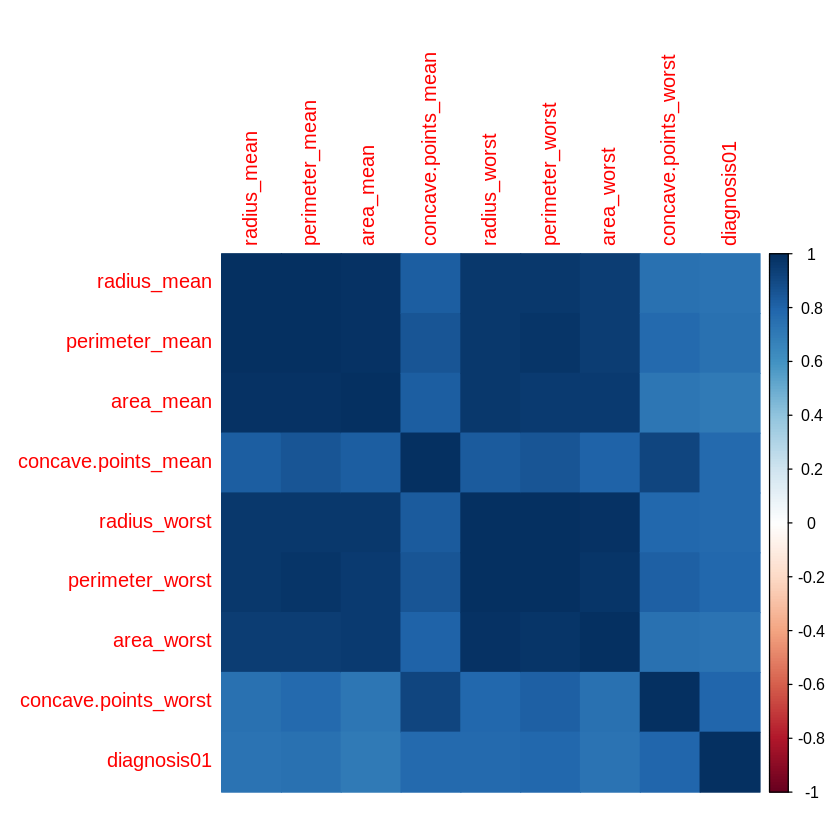

In [6]:
#finding multicollinearity between independent variables
df <- BC[,c("radius_mean","perimeter_mean","area_mean", "concave.points_mean", "radius_worst", "perimeter_worst", "area_worst", "concave.points_worst", "diagnosis01")]

# Calculate the correlation matrix
cor_matrix <- cor(df)
install.packages("corrplot")
library(corrplot)
corrplot(cor_matrix, method="color")


radius_mean, perimeter_mean, area_mean, radius_worst, perimeter_worst, area_worst: These variables appear to have very high correlation with each other (values close to 1). This suggests high multicollinearity among these variables.

Thus, we will focus on variables like concave.points_mean and concave.points_worst for building our prediction model, as they seem to have stronger relationships with diagnosis01. We will also select one representative variable from each group of highly correlated variables-- radius_mean and radius_worst.

In [7]:
DF1 <- df[,c("radius_mean", "concave.points_mean", "radius_worst", "concave.points_worst", "diagnosis01")]

### 2.2: Prediction Diagnosis of Breast Cancer

We begin the analysis by splitting the data, using the 70/30 ratio.

In [8]:
#to make sure we get the same results for randomization
set.seed(13)

#taking 70% of the data for training
train.size <-  nrow(DF1) * 0.7

#taking a sample of the total rows by the number of train.size
train <-  sample(1:nrow(DF1), train.size) #sample of the rows of the training set
test <-  -train #the other 30% for test - this is done by indexing.

#subsetting the data set by the train and test rows respectively
DF1.train <-  DF1[train, ]
DF1.test <-  DF1[test, ]
diagnosis01.test <-  diagnosis01[test]

#### 2.2.1: Linear Discriminant Analysis

The linear discriminant analysis (LDA) finds a linear combination of features that best separates the classes in a data set. We will be using the `lda()` function from the `MASS` package to fit the LDA model to our data.

LDA is a dimensionality reduction technique. Assume that a bunch of data belongs to 2 groups. Each observation has different features (different values for each variable) hence we need to create a rule that helps decide which group each observation belong to.

In [9]:
#load the package
library(MASS)

#training the model
lda.fit <-  lda(diagnosis01 ~  concave.points_mean + concave.points_worst + radius_mean + radius_worst, data = DF1.train)
lda.fit #view model output

#predicting on test set
lda.pred <- predict(lda.fit, DF1.test)
names(lda.pred) #returns the names of the components within the lda.pred list
head(lda.pred$class) #view predicted class for first six observations in test set
head(lda.pred$posterior) #view posterior probabilities for first six observations in test set; probabilities indicate how confident the model is about each prediction
head(lda.pred$x) #view linear discriminants for first six observations in test set


#finding misclassification error rate (MER), which gives the proportion of incorrect predictions
mean(lda.pred$class != diagnosis01.test) #creates a logical vector where each entry is TRUE if the predicted class does not match the actual class, and FALSE otherwise
LDAMER <- mean(lda.pred$class != diagnosis01.test)

Call:
lda(diagnosis01 ~ concave.points_mean + concave.points_worst + 
    radius_mean + radius_worst, data = DF1.train)

Prior probabilities of groups:
        0         1 
0.6482412 0.3517588 

Group means:
  concave.points_mean concave.points_worst radius_mean radius_worst
0          0.02667181            0.0768624    12.17950     13.42559
1          0.09022679            0.1858921    17.55879     21.26043

Coefficients of linear discriminants:
                           LD1
concave.points_mean   8.083511
concave.points_worst 12.445380
radius_mean          -0.206809
radius_worst          0.323188

[1] "class"     "posterior" "x"

[1] 1 1 1 1 1 0
Levels: 0 1

,0,1
3,0.0001064207,0.9998936
4,0.0038473388,0.9961527
7,0.0026745886,0.9973254
8,0.2878924969,0.7121075
10,0.0465403731,0.9534596
11,0.8015867369,0.1984133


,LD1
3,3.4538433
4,2.3623075
7,2.4731673
8,0.9487978
10,1.5913326
11,0.2492020


[1] 0.0877193

understanding the outputs:

Prior probabilities are the initial probabilities of each class before observing any features of the data. They reflect the proportion of each class in the training dataset. Based on the prior probabilities of groups, approximately 64.82% of the observations in the training dataset belong to class 0 and approximately 35.18% of the observations in the training dataset belong to class 1.

Posterior probabilities are the probabilities of each class given the observed features. They are calculated using Bayes' theorem and combine the prior probabilities with the likelihood of the observed data under each class.


LDA has a 8.77% test error rate.


#### 2.2.2: Quadratic Discriminant Analysis

The quadratic discriminant analysis (QDA) finds a non-linear combination of features that best separates the classes in a data set. Similarly, we will be using the `qda()` function from the `MASS` package to fit the QDA model to our data.

QDA works similarly to LDA, but instead of finding the best linear line, QDA finds the best quadratic, or curve line, to separate the 2 groupings.

In [10]:
# learn the model
qda.fit <-  qda(diagnosis01 ~ concave.points_mean + concave.points_worst + radius_mean + radius_worst,
                data = DF1.train)

qda.fit #view model output

# form the prediction on test set
qda.pred <-  predict(qda.fit, DF1.test)
names(qda.pred)
head(qda.pred$class) #view predicted class for first six observations in test set
head(qda.pred$posterior) #view posterior probabilities for first six observations in test set

#compute estimate of test error
#mean where prediction does not match the real value
mean(qda.pred$class != diagnosis01.test)
QDAMER <- mean(qda.pred$class != diagnosis01.test)

Call:
qda(diagnosis01 ~ concave.points_mean + concave.points_worst + 
    radius_mean + radius_worst, data = DF1.train)

Prior probabilities of groups:
        0         1 
0.6482412 0.3517588 

Group means:
  concave.points_mean concave.points_worst radius_mean radius_worst
0          0.02667181            0.0768624    12.17950     13.42559
1          0.09022679            0.1858921    17.55879     21.26043

[1] "class"     "posterior"

[1] 1 1 1 1 1 1
Levels: 0 1

,0,1
3,4.415984e-15,1.0000000
4,2.624862e-10,1.0000000
7,3.469729e-13,1.0000000
8,6.456856e-05,0.9999354
10,4.798025e-04,0.9995202
11,4.299438e-03,0.9957006


[1] 0.07017544

The prior probabilities indicates that class 0 is nearly twice as prevalent as class 1 in the training data. The posterior probabilities on the other hand indicate that the model is extremely confident in predicting class 1 for these observations, as the posterior probabilities for class 1 are very close to 1 (and the probabilities for class 0 are close to 0).

QDA has a 7.02% test error rate. Since the MER is low, the model is likely performing well despite the extreme confidence in predictions.


#### 2.2.3: Logistic Regression

Logistic regression predicts the categorical dependent variable using a given set of independent variables. We will be using the `glm()` function and specify `family=”binomial”` so that R fits a logistic regression model to the data set. GLM stands for general linear model.

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = diagnosis01 ~ concave.points_mean + concave.points_worst + 
    radius_mean + radius_worst, family = binomial, data = DF1.train)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -21.9668     3.9878  -5.508 3.62e-08 ***
concave.points_mean   43.3548    27.8526   1.557   0.1196    
concave.points_worst  27.1605    13.5920   1.998   0.0457 *  
radius_mean           -1.9825     0.6869  -2.886   0.0039 ** 
radius_worst           2.7236     0.6527   4.173 3.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 516.229  on 397  degrees of freedom
Residual deviance:  70.058  on 393  degrees of freedom
AIC: 80.058

Number of Fisher Scoring iterations: 9


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: fields

Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridisLite


Try help(fields) to get started.

Loading required package: boot

Loading required package: CircStats

Loading required package: dtw

Loading required package: proxy


Attaching package: ‘proxy’


The following object is masked from ‘package:spam’:

    as.matrix


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Loaded dtw v1.23-1. See ?d

[1] 0.9813412

[1] 0.05263158

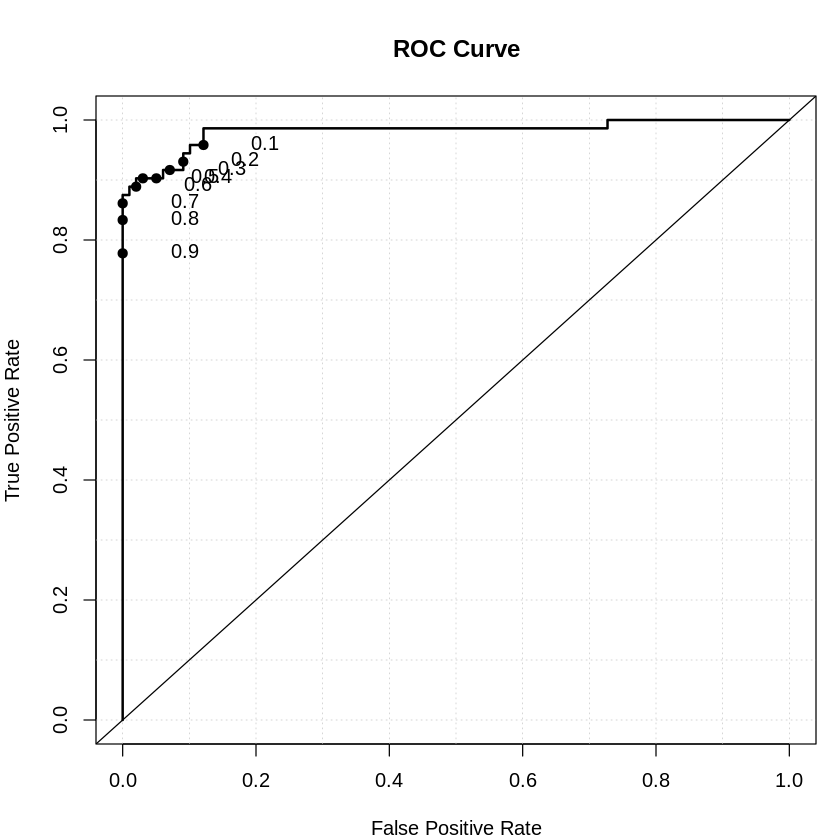

In [11]:
#training model
glm.fit <-  glm(diagnosis01 ~ concave.points_mean + concave.points_worst + radius_mean + radius_worst,
              data = DF1.train,
              family = binomial)
summary(glm.fit) #view model summary

#obtain predictions on test set
glm.probs <-  predict(glm.fit, DF1.test, type = "response") #probability that each observation is malignant
#using a threshold to decide on final diagnosis
glm.pred <-  rep(0, length(glm.probs))
glm.pred[glm.probs > 0.7] <- 1 #threshold chosen is 0.7; any observation with a probability greater than 0.7 is classified as malignant (1), and others as benign (0)

#creating ROC curve
install.packages("verification")
library(verification)
roc.plot(diagnosis01.test, glm.probs, xlab = "False Positive Rate",
ylab = "True Positive Rate")
#calculating AUC value
roc.area(diagnosis01.test, glm.probs)$A

#evaluate prediction quality
mean(glm.pred != diagnosis01.test)
LogRegMER <- mean(glm.pred != diagnosis01.test)

understanding the output:
The ROC curve is close to the top-left corner. This suggests that the model has a high true positive rate and a low false positive rate, indicating good performance.
An AUC of 0.98 indicates that there is a 98% chance that the model will correctly distinguish between a randomly chosen positive instance (e.g., a malignant tumor) and a randomly chosen negative instance (e.g., a benign tumor).


Logistic Regression has a 5.26% test error rate.



#### 2.2.4: K-Nearest Neighbour

The K-Nearest Neighbor (KNN) algorithm stores all the available data and classifies a new data point based on the similarity. We will be using the `knn()` function from the `class` package to fit the KNN model to our data.

In [12]:
library(class)

#binding the feature values by column for the train and test set respectively.
train.X <- cbind(DF1$radius_mean, DF1$concave.points_mean, DF1$radius_worst, DF1$concave.points_worst)[train,]

test.X <- cbind(DF1$radius_mean, DF1$concave.points_mean, DF1$radius_worst, DF1$concave.points_worst)[test,]

train.diagnosis01 <-  diagnosis01[train]

set.seed(13)
# KNN (k=7)
knn.pred7 <-  knn(train.X, test.X, train.diagnosis01, k = 7)
mean(knn.pred7 != diagnosis01.test)
KNN7MER <- mean(knn.pred7 != diagnosis01.test)

# KNN (k=12)
knn.pred12 <-  knn(train.X, test.X, train.diagnosis01, k = 12)
mean(knn.pred12 != diagnosis01.test)
KNN12MER <- mean(knn.pred12 != diagnosis01.test)

# KNN (k=23)
knn.pred23 <-  knn(train.X, test.X, train.diagnosis01, k = 23)
mean(knn.pred23 != diagnosis01.test)
KNN23MER <- mean(knn.pred23 != diagnosis01.test)

[1] 0.09356725

[1] 0.08187135

[1] 0.0994152

**k=7 has a 9.36% test error rate. k=12 has 8.19% test error rate. k=23 has a 9.94% test error rate. K of 12 seems to perform the best.**

We can try cross-validation to find the best K value.


### 2.3: Final Analyisis

In [13]:
#creating a table of overall results
mervalues <- matrix(c(LDAMER, QDAMER, LogRegMER, KNN7MER, KNN12MER, KNN23MER), ncol=1)
colnames(mervalues) <- c('MER values')
rownames(mervalues) <- c('LDA','QDA','Log Reg', 'KNN (K=7)', 'KNN (K=12)', 'KNN (K=23)')
as.table(mervalues)

           MER values
LDA        0.08771930
QDA        0.07017544
Log Reg    0.05263158
KNN (K=7)  0.09356725
KNN (K=12) 0.08187135
KNN (K=23) 0.09941520

**Logistic Regression achieved the lowest test error rate.**
Logistic Regression appears to be the most suitable model for this dataset based on the MER values. If interpretability is important, Logistic Regression and LDA might be preferable due to their simpler models compared to QDA and KNN.

# 3 | Supervised Learning: Regression

Regression is a type of supervised machine learning where algorithms learn from the data to predict a continuous value. In this part of the report, we will be using the Boston data set from the MASS package to predict the median value of owner-occupied homes in suburbs of Boston.

### 3.1: EDA

Once again, we start off with some exploratory data analysis.

In [14]:
#loading the data
library(MASS)

#checking for NA value
sum(is.na(Boston))

#standardize the data using Z-score standardization
scaled_data <- scale(Boston)

#convert the scaled matrix to a DataFrame
df <- as.data.frame(scaled_data)

#assign the original column names to the scaled DataFrame
colnames(df) <- colnames(Boston)

#observing the structure
str(df)

[1] 0

'data.frame':	506 obs. of  14 variables:
 $ crim   : num  -0.419 -0.417 -0.417 -0.416 -0.412 ...
 $ zn     : num  0.285 -0.487 -0.487 -0.487 -0.487 ...
 $ indus  : num  -1.287 -0.593 -0.593 -1.306 -1.306 ...
 $ chas   : num  -0.272 -0.272 -0.272 -0.272 -0.272 ...
 $ nox    : num  -0.144 -0.74 -0.74 -0.834 -0.834 ...
 $ rm     : num  0.413 0.194 1.281 1.015 1.227 ...
 $ age    : num  -0.12 0.367 -0.266 -0.809 -0.511 ...
 $ dis    : num  0.14 0.557 0.557 1.077 1.077 ...
 $ rad    : num  -0.982 -0.867 -0.867 -0.752 -0.752 ...
 $ tax    : num  -0.666 -0.986 -0.986 -1.105 -1.105 ...
 $ ptratio: num  -1.458 -0.303 -0.303 0.113 0.113 ...
 $ black  : num  0.441 0.441 0.396 0.416 0.441 ...
 $ lstat  : num  -1.074 -0.492 -1.208 -1.36 -1.025 ...
 $ medv   : num  0.16 -0.101 1.323 1.182 1.486 ...


In [15]:
cor1 <- cor(df) #correlation of data set
results <- as.table(cor1[,14]) #table of correlations between `medv' with other variables
results[abs(results) > 0.5] #high correlations

        rm    ptratio      lstat       medv 
 0.6953599 -0.5077867 -0.7376627  1.0000000 

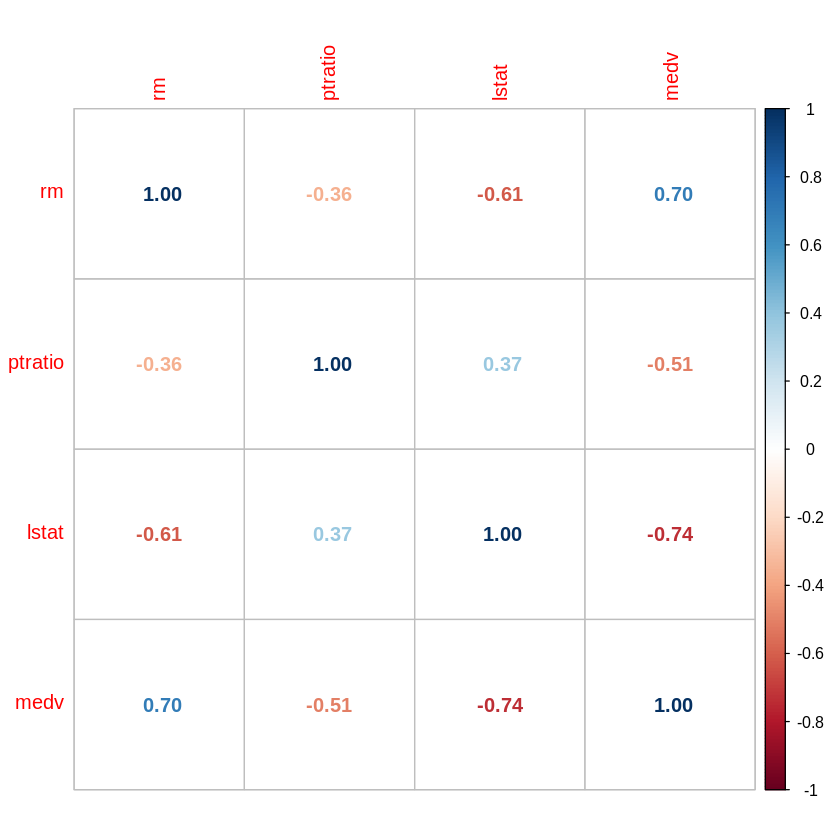

In [16]:
#finding multicollinearity between independent variables
df1 <- df[,c("rm","ptratio","lstat", "medv")]

#calculate the correlation matrix
cor_matrix <- cor(df1)
library(corrplot)
corrplot(cor_matrix, method="number")

### 3.2: Predicting the Median Housing Value in Boston

We start off by splitting the data into training and testing sets using the same 70/30 ratio.

In [17]:
#split the data
train.size2 <-  nrow(df) * 0.7 #taking 70% of the data for training

#taking a sample of the total rows by the number of train.size
train2 <-  sample(1:nrow(df), train.size2) #sample of the rows of the training set
test2 <-  -train2 #the other 30% for test - this is done by indexing.

#subset the Boston data set by the train and test rows respectively
df.train <-  df[train2, ]
df.test <-  df[test2, ]

#### 3.2.1: Linear Regression

Linear regression model is a basic and commonly used type of predictive analysis - it assumes a linear relationship between the independent variable and the dependent variable, and aims to find the best-fitting line that describes the relationship.

In [18]:
#fitting a linear model using least squares on training data
lm.fit <-  lm(medv ~ rm + ptratio + lstat, data = df.train)
#view model summary
summary(lm.fit)

#predicting on test data
lm.pred <-  predict(lm.fit, df.test)

#evaluate prediction quality using MSE
mean((df.test[, "medv"] - lm.pred)^2)
MSELM <- mean((df.test[, "medv"] - lm.pred)^2)


Call:
lm(formula = medv ~ rm + ptratio + lstat, data = df.train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.43657 -0.32983 -0.09082  0.20075  3.14668 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0005739  0.0293712   0.020    0.984    
rm           0.3057953  0.0372837   8.202 4.56e-15 ***
ptratio     -0.2374358  0.0310105  -7.657 1.88e-13 ***
lstat       -0.4582276  0.0385202 -11.896  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5525 on 350 degrees of freedom
Multiple R-squared:  0.6815,	Adjusted R-squared:  0.6787 
F-statistic: 249.6 on 3 and 350 DF,  p-value: < 2.2e-16


[1] 0.368349

**Least Squares has a MSE of 36.83.**

We now try fitting a least squares model with an interaction term.

In [19]:
#fitting a linear model using least squares on training data
lm.fit1 <-  lm(medv ~ rm + ptratio + lstat + rm*lstat, data = df.train)
#view model summary
summary(lm.fit1)

#predicting on test data
lm.pred1 <-  predict(lm.fit1, df.test)

#evaluate prediction quality using MSE
mean((df.test[, "medv"] - lm.pred1)^2)
MSELMX <- mean((df.test[, "medv"] - lm.pred1)^2)


Call:
lm(formula = medv ~ rm + ptratio + lstat + rm * lstat, data = df.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1225 -0.2576 -0.0629  0.2048  3.4418 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.15186    0.02857  -5.315 1.91e-07 ***
rm           0.21502    0.03296   6.524 2.40e-10 ***
ptratio     -0.15444    0.02758  -5.599 4.36e-08 ***
lstat       -0.63539    0.03656 -17.378  < 2e-16 ***
rm:lstat    -0.24884    0.02205 -11.283  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4736 on 349 degrees of freedom
Multiple R-squared:  0.7666,	Adjusted R-squared:  0.7639 
F-statistic: 286.6 on 4 and 349 DF,  p-value: < 2.2e-16


[1] 0.2981142

This method allows the model to capture not only the main effects of each predictor but also the combined effect of two (or more) predictors interacting with each other. Least Squares with an interaction term has a MSE of 29.81.

#### 3.2.2: Best Subset

The best subset algorithm helps us pick the best model out of the many models we can potentially build with 13 features and one target. The `regsubsets()` function is for model selection, done by exhaustive search. It fits the input to every output/group of outputs, compare the models and find the one with the least error/BIC.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



(Intercept)         crim           zn          nox           rm          dis 
 0.005992384 -0.122980278  0.168601471 -0.222250646  0.248071233 -0.379565593 
         rad          tax      ptratio        black        lstat 
 0.290936762 -0.250374343 -0.215615684  0.087708746 -0.406314807

[1] 0.3412832

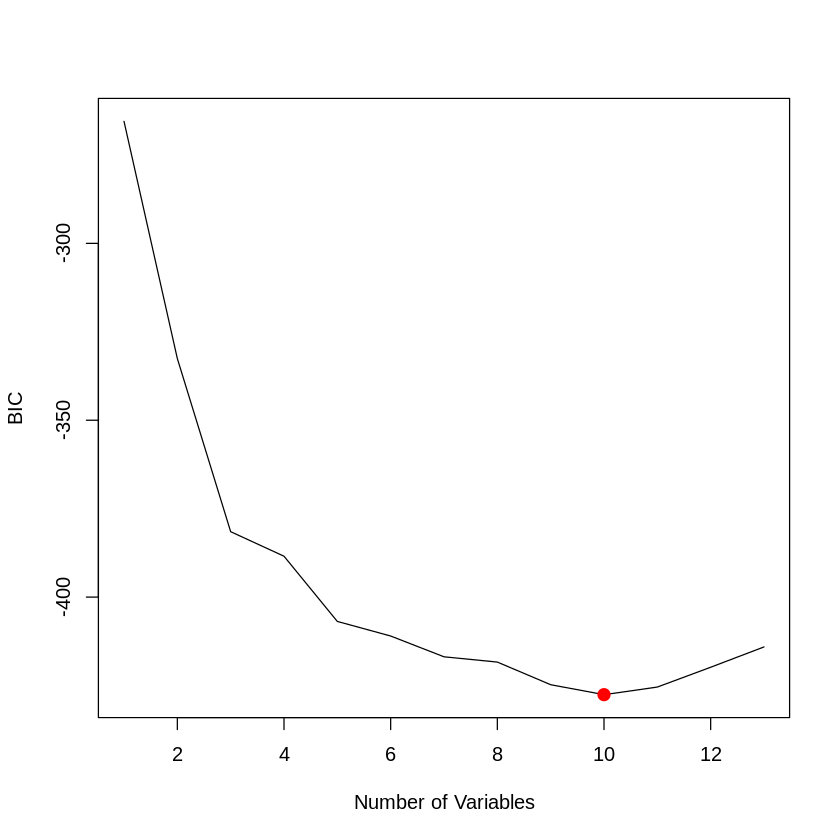

In [20]:
install.packages('leaps')
library(leaps)

#model selection
regfit.full <- regsubsets(medv ~ . , data = df.train, nvmax=15)

reg.summary <- summary(regfit.full)
best.model <- which.min(reg.summary$bic) #number of variables with the smallest BIC value
#plotting the BIC curve across the number of variables
plot(reg.summary$bic,xlab="Number of Variables",ylab="BIC",type='l')
points(best.model,reg.summary$bic[best.model], col="red",cex=2,pch=20)

#predictions on test set
Xtest <- model.matrix(medv ~ . , data = df.test) #creates a model matrix from the df.test, which includes all predictor variables for making predictions
#taking the estimated parameters from the model with lowest BIC
coefbest <- coef(regfit.full,best.model) #extracts the coefficients of the predictors for the best model
coefbest
#'%*%' means matrix multiplication
pred <- Xtest[,names(coefbest)]%*%coefbest #subsets the Xtest matrix to include only the predictors in the best model, then performs matrix multiplication to calculate the predicted values pred

#mse
mean((df.test$medv-pred)^2)
MSEBS <- mean((df.test$medv-pred)^2)


Lower BIC values indicate better model fit with an appropriate penalty for the number of predictors to avoid overfitting. The best-subsets regression analysis has identified the optimal model with 10 predictor variables.


**Best Subsets has a MSE of 34.13.**



#### 3.2.3: Ridge Regression

Ridge regression is a model tuning method that is used to analyse any data that suffers from multicollinearity. We’ll use the `glmnet()` function to fit the ridge regression model and specify `alpha=0`.

In [21]:
set.seed(1)
install.packages('glmnet')
library(glmnet)
train.mat <-  model.matrix(medv ~ . , data = df.train)
test.mat <-  model.matrix(medv ~ . , data = df.test)

#cross validation code to find lambda value
grid <-  10 ^ seq(4, -2, length = 100)
mod.ridge <-  cv.glmnet(train.mat, df.train[, "medv"],
                        alpha = 0, lambda = grid, thresh = 1e-12)
lambda.best <-  mod.ridge$lambda.min #extracts the lambda value that resulted in the lowest cross-validated error
lambda.best

#prediction
ridge.pred <-  predict(mod.ridge, newx = test.mat, s = lambda.best)
mean((df.test[, "medv"] - ridge.pred)^2)
MSERidge <- mean((df.test[, "medv"] - ridge.pred)^2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:spam’:

    det


Loaded glmnet 4.1-8



[1] 0.01

[1] 0.3320939

**Ridge Regression has a MSE of 33.21.**

####3.2.4: Lasso Regression

Lasso regression is another model tuning method, similar to ridge, that is used to analyse data with multicollinearity present. We’ll use the `glmnet()` function as well to fit the lasso regression model but specify `alpha=1` instead.

In [22]:
#cross validation code to find lambda value
mod.lasso <-  cv.glmnet(train.mat, df.train[, "medv"],
                        alpha = 1, lambda = grid, thresh = 1e-12)
lambda.best <-  mod.lasso$lambda.min
lambda.best

#prediction
lasso.pred <-  predict(mod.lasso, newx = test.mat, s = lambda.best)
mean((df.test[, "medv"] - lasso.pred)^2)
MSELasso <- mean((df.test[, "medv"] - lasso.pred)^2)

#obtain the coefficient estimates
mod.lasso <-  glmnet(model.matrix(medv ~ . , data = df),
                     df[, "medv"], alpha = 1)
predict(mod.lasso, s = lambda.best, type = "coefficients")

[1] 0.01

[1] 0.3313297

15 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept) -2.420101e-16
(Intercept)  .           
crim        -7.120694e-02
zn           8.015229e-02
indus        .           
chas         7.189362e-02
nox         -1.750523e-01
rm           3.063481e-01
age          .           
dis         -2.697704e-01
rad          1.413582e-01
tax         -1.012096e-01
ptratio     -2.102326e-01
black        8.366203e-02
lstat       -4.055880e-01

**Lasso Regression has a MSE of 33.13.**

### 3.3: Final Analysis

In [23]:
#creating a table of overall results
msevalues <- matrix(c(MSELM, MSELMX, MSEBS, MSERidge, MSELasso), ncol=1)
colnames(msevalues) <- c('MSE values')
rownames(msevalues) <- c('Least Squares', 'Least Squares (w interaction)', 'Best Subset','Ridge', 'Lasso')
as.table(msevalues)

                              MSE values
Least Squares                  0.3683490
Least Squares (w interaction)  0.2981142
Best Subset                    0.3412832
Ridge                          0.3320939
Lasso                          0.3313297

**Least Squares with interaction effect is the best performing model.**
Including interaction terms significantly improves model performance, as indicated by the lowest MSE. This suggests that the interactions between variables are crucial in this dataset. Both Ridge and Lasso regression improve performance compared to the ordinary least squares model. This indicates that regularization helps to handle overfitting and multicollinearity. For further improvements, we can consider combining interactions with regularization (interaction terms with Ridge or Lasso regression) to balance complexity and predictive performance.